# analyze_fit_us_data.ipynb

Analyze the curves that [fit_us_data.ipynb](./fit_us_data.ipynb) fit to the COVID-19 time series.

Inputs:
* `outputs/us_counties_curves.csv`: Curves generated by [fit_us_data.ipynb](./fit_us_data.ipynb)
* `outputs/us_counties_curves_meta.json`: Column type metadata for reading `data/us_counties_curves.csv` with `pd.read_csv()`
* `outputs/us_counties_curves_params.csv`: Model parameters corresponding to the curves in `data/us_counties_curves.csv`

**Note:** You can redirect these input files by setting the environment variable `COVID_OUTPUTS_DIR` to a replacement for the prefix `outputs` in the above paths.

In [1]:
# Initialization boilerplate
import os
import json
import pandas as pd
import numpy as np
import scipy.optimize
from sklearn import metrics

from typing import *

import text_extensions_for_pandas as tp

# Local file of utility functions
import util

# Allow environment variables to override data file locations.
_OUTPUTS_DIR = os.getenv("COVID_OUTPUTS_DIR", "outputs")
util.ensure_dir_exists(_OUTPUTS_DIR)  # create if necessary

# Read and reformat input data

## Load the time series data

In [2]:
csv_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves.csv")
meta_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_meta.json")

# Read column type metadata
with open(meta_file) as f:
    curves_meta = json.load(f)

# Pandas does not currently support parsing datetime64 from CSV files.
# As a workaround, read the "Date" column as objects and manually 
# convert after.
curves_meta["Date"] = "object"

curves_vertical = (
    pd
    .read_csv(csv_file, dtype=curves_meta, parse_dates=["Date"])   
    .set_index(["FIPS", "Date"], verify_integrity=True)
)
curves_vertical

State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               153   
      2020-03-11  Alabama  Autauga       55869               153   
      2020-03-12  Alabama  Autauga       55869               153   
      2020-03-13  Alabama  Autauga       55869               153   
      2020-03-14  Alabama  Autauga       55869               153   
...                   ...      ...         ...               ...   
56045 2020-11-19  Wyoming   Weston        6927                34   
      2020-11-20  Wyoming   Weston        6927                34   
      2020-11-21  Wyoming   Weston        6927                34   
      2020-11-22  Wyoming   Weston        6927                34   
      2020-11-23  Wyoming   Weston        6927                34   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              3          0              False     1.000000   
      2020-03-11              3          0              False     1.032682   
      2020-03-12              3          0              False     1.066432   
      2020-03-13              3          0              False     1.101285   
      2020-03-14              3          0              False     1.137277   
...                         ...        ...                ...          ...   
56045 2020-11-19              1        355              False   374.457859   
      2020-11-20              1        364              False   390.161780   
      2020-11-21              1        366              False   406.524288   
      2020-11-22              1        372              False   423.573003   
      2020-11-23              1        372              False   441.336703   

                    Logistic   Logistic2  
FIPS  Date                                
1001  2020-03-10   39.075883   28.842652  
      2020-03-11   40.059377   29.476065  
      2020-03-12   41.067225   30.123645  
      2020-03-13   42.100011   30.785730  
      2020-03-14   43.158330   31.462672  
...                      ...         ...  
56045 2020-11-19  365.682229  365.682191  
      2020-11-20  374.435530  374.435458  
      2020-11-21  382.984690  382.984581  
      2020-11-22  391.316682  391.316532  
      2020-11-23  399.420159  399.419968  

[769230 rows x 10 columns]

In [3]:
# Name of the column that bgfs.ipynb analyzed
ts_col_name = "Confirmed"
outlier_col_name = ts_col_name + "_Outlier"
metadata_cols = ["State", "County", "Population"]

In [4]:
# As a workaround for a bug in Pandas' extension types system,
# we need to cast the boolean columns to ints.
curves_vertical[outlier_col_name] = curves_vertical[outlier_col_name].astype(np.int8)
curves_vertical

State   County  Population  Confirmed_7_Days  \
FIPS  Date                                                         
1001  2020-03-10  Alabama  Autauga       55869               153   
      2020-03-11  Alabama  Autauga       55869               153   
      2020-03-12  Alabama  Autauga       55869               153   
      2020-03-13  Alabama  Autauga       55869               153   
      2020-03-14  Alabama  Autauga       55869               153   
...                   ...      ...         ...               ...   
56045 2020-11-19  Wyoming   Weston        6927                34   
      2020-11-20  Wyoming   Weston        6927                34   
      2020-11-21  Wyoming   Weston        6927                34   
      2020-11-22  Wyoming   Weston        6927                34   
      2020-11-23  Wyoming   Weston        6927                34   

                  Deaths_7_Days  Confirmed  Confirmed_Outlier  Exponential  \
FIPS  Date                                                                   
1001  2020-03-10              3          0                  0     1.000000   
      2020-03-11              3          0                  0     1.032682   
      2020-03-12              3          0                  0     1.066432   
      2020-03-13              3          0                  0     1.101285   
      2020-03-14              3          0                  0     1.137277   
...                         ...        ...                ...          ...   
56045 2020-11-19              1        355                  0   374.457859   
      2020-11-20              1        364                  0   390.161780   
      2020-11-21              1        366                  0   406.524288   
      2020-11-22              1        372                  0   423.573003   
      2020-11-23              1        372                  0   441.336703   

                    Logistic   Logistic2  
FIPS  Date                                
1001  2020-03-10   39.075883   28.842652  
      2020-03-11   40.059377   29.476065  
      2020-03-12   41.067225   30.123645  
      2020-03-13   42.100011   30.785730  
      2020-03-14   43.158330   31.462672  
...                      ...         ...  
56045 2020-11-19  365.682229  365.682191  
      2020-11-20  374.435530  374.435458  
      2020-11-21  382.984690  382.984581  
      2020-11-22  391.316682  391.316532  
      2020-11-23  399.420159  399.419968  

[769230 rows x 10 columns]

## Collapse each time series down to a single cell

This kind of time series data is easier to manipulate at the macroscopic level if each time series occupies a 
single cell of the DataFrame. We use the [TensorArray](https://text-extensions-for-pandas.readthedocs.io/en/latest/#text_extensions_for_pandas.TensorArray) Pandas extension type from [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas).

In [5]:
curves, dates = util.collapse_time_series(curves_vertical, [
    ts_col_name, outlier_col_name,
    "Exponential", "Logistic", "Logistic2"])
curves

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Confirmed,Confirmed_Outlier,Exponential,Logistic,Logistic2
FIPS,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03268179e+00 1.06643168e+00 1...,[ 39.07588299 40.05937659 41.06722489 42...,[ 28.84265226 29.47606541 30.12364459 30...
1003,Alabama,Baldwin,223234,573,0,[ 0 0 0 0 0 1 1 1 1 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03739188e+00 1.07618191e+00 1...,[ 34.54996183 35.697209 36.88236758 38...,[ 265.70155073 265.30291246 264.92597651 264...
1005,Alabama,Barbour,24686,31,1,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02964589e+00 1.06017065e+00 1...,[ 20.91097258 21.47629938 22.05660754 22...,[7.26384030e-08 2.05098635e-07 5.79100551e-07 1...
1007,Alabama,Bibb,22394,149,0,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02892515e+00 1.05868696e+00 1...,[ 15.69551022 16.06587096 16.44484264 16.832...,[ 3.89092371 4.03793868 4.19045362 4...
1009,Alabama,Blount,57826,189,2,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.03265475e+00 1.06637584e+00 1...,[ 16.48050222 16.9434894 17.4193997 17...,[5.40108077e-08 1.48336048e-07 4.07372177e-07 1...
...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02824538e+00 1.05728857e+00 1...,[ 3.84415638 3.93823724 4.03461606 4...,[6.48186571e-01 7.21136490e-01 8.01099864e-01 8...
56039,Wyoming,Teton,23464,241,0,[ 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[1.00000000e+00 1.02910053e+00 1.05904789e+00 1...,[ 20.95561488 21.33565057 21.72251319 22...,[ 8.2777716 8.67834295 9.10516567 9...
56041,Wyoming,Uinta,20226,190,0,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,[ 1. 1.02712193 1.05497947 1.083...,[ 19.9218464 20.24534842 20.57402494 20.907...,[ 9.14988175 9.48469471 9.82883674 10.182...


## Load the parameters of the curves that `fit_us_data.ipynb` fit

In [6]:
params_data_file = os.path.join(_OUTPUTS_DIR, "us_counties_curves_params.csv")
params = pd.read_csv(params_data_file).set_index("FIPS", verify_integrity=True)
params

,State,County,Population,Confirmed_7_Days,Deaths_7_Days,Exp_Rate,Exp_Offset,Log_Max,Log_Rate,Log_Offset,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,,,,,,,,
1001,Alabama,Autauga,55869,153,3,0.032159,0.000000,2588.942416,0.025243,165.522271,712.386798,0.072317,117.666975,6595.429632,0.000972,258.999811,211.681399,258.999964
1003,Alabama,Baldwin,223234,573,0,0.036710,0.000000,7693.435432,0.032816,164.591587,989.860929,0.000000,37.533129,8534.774774,0.037192,155.780454,0.000000,133.331887
1005,Alabama,Barbour,24686,31,1,0.029215,0.000000,1136.381406,0.027183,146.296390,923.883669,9.780670,29.777387,954.668952,0.038310,125.773999,12.472659,11.472668
1007,Alabama,Bibb,22394,149,0,0.028515,0.000000,1135.701311,0.023653,180.428326,1037.938977,0.105521,236.273356,1083.114902,0.035398,138.899231,0.028724,259.000000
1009,Alabama,Blount,57826,189,2,0.032133,0.000000,2726.924145,0.027876,183.046371,880.093449,9.957865,27.595491,1362.224234,0.015063,51.618109,16.795297,15.795297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,438,2,0.027854,0.000000,2044.183641,0.024225,259.000000,1803.509889,0.071085,259.000000,2043.562076,0.024209,259.000000,10.000051,20.000019
56039,Wyoming,Teton,23464,241,0,0.028685,0.000000,2319.836531,0.018138,259.000000,2046.427809,0.022727,259.000000,2317.021100,0.018087,259.000000,10.000025,19.999971
56041,Wyoming,Uinta,20226,190,0,0.026761,0.000000,1393.049826,0.016344,259.000000,1216.157278,10.000000,259.000000,1377.965813,0.015854,259.000000,4.508973,33.314464


## Calculate goodness of fit

Create a dataframe of R^2 (coefficient of determination) values to measure how well each curve fit each series.

In [7]:
def compute_r_squared(colname):
    return [
        metrics.r2_score(
            curves.loc[fips][ts_col_name], curves.loc[fips][colname])
            for fips in curves.index
    ]

stats = curves[metadata_cols].copy()
stats["Exp_R^2"] = compute_r_squared("Exponential")
stats["Log_R^2"] = compute_r_squared("Logistic")
stats["Log2_R^2"] = compute_r_squared("Logistic2")
stats

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1001,Alabama,Autauga,55869,0.276805,0.990342,0.998202
1003,Alabama,Baldwin,223234,0.282758,0.987364,0.986051
1005,Alabama,Barbour,24686,0.148686,0.991442,0.972747
1007,Alabama,Bibb,22394,0.493599,0.988954,0.998005
1009,Alabama,Blount,57826,0.537894,0.982982,0.453860
...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,0.873723,0.874225,0.874243
56039,Wyoming,Teton,23464,0.740683,0.967678,0.967809
56041,Wyoming,Uinta,20226,0.679381,0.911987,0.915456


In [8]:
# Compute some summary statistics of our summary statistics
stats[["Exp_R^2", "Log_R^2", "Log2_R^2"]].describe()

,Exp_R^2,Log_R^2,Log2_R^2
count,2970.000000,2970.000000,2970.000000
mean,0.381673,0.952642,0.962233
std,0.989993,0.104542,0.090960
min,-8.740880,0.157886,0.192528
25%,0.293836,0.954929,0.965813
50%,0.736968,0.980787,0.986832
75%,0.940510,0.990517,0.995003
max,0.998513,0.999125,0.999812


In [9]:
# Based on the stats above, it looks like R^2 >= 0.99 is a useful cutoff
# for "the curve fits the data"
r2_thresh = 0.99

# Let's see how many counties fit our curves at least that well.
print(f"""\
 Exp_R^2: {(stats['Exp_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
 Log_R^2: {(stats['Log_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
Log2_R^2: {(stats['Log2_R^2'] >= r2_thresh).sum()} of {len(stats.index)} counties have R^2 >= {r2_thresh}
"""
)

 Exp_R^2: 112 of 2970 counties have R^2 >= 0.99
 Log_R^2: 797 of 2970 counties have R^2 >= 0.99
Log2_R^2: 1247 of 2970 counties have R^2 >= 0.99



# Break down time series according to curve characteristics

The R^2 metrics divide the time series into several groups. Let's look at examples of each of these groups in turn.

## Time series that can be explained by an exponential growth model

Identify time series for which a single exponential curve has R^2 above 0.99

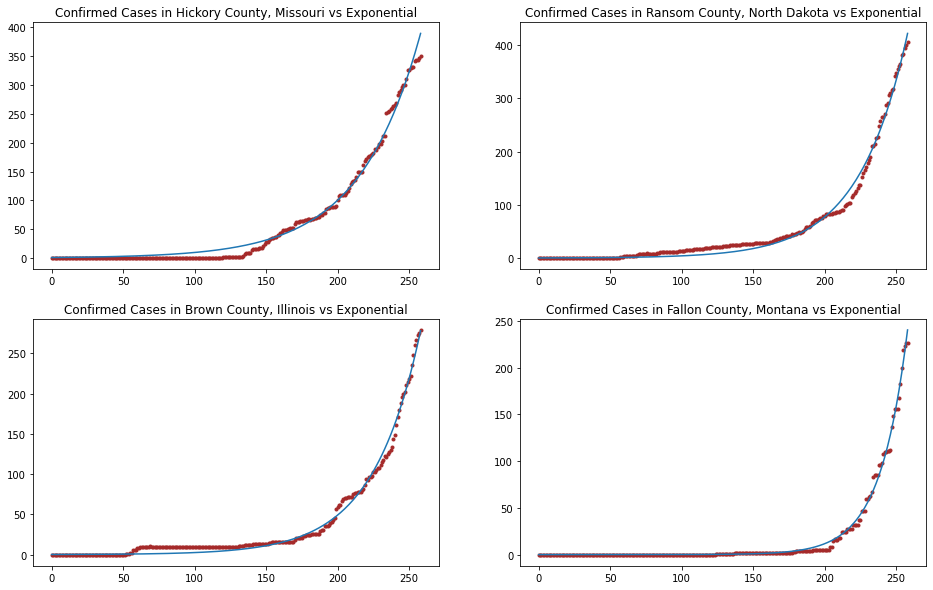

In [10]:
util.graph_examples(curves, ts_col_name, {"Exponential": curves["Exponential"]},
                    mask=stats['Exp_R^2'] >= r2_thresh)

## Time series that are better explained by logistic growth

Let's look at some examples where logistic growth (with a single
instance of the logistic function) produces a good fit, while an
exponential growth model does not.

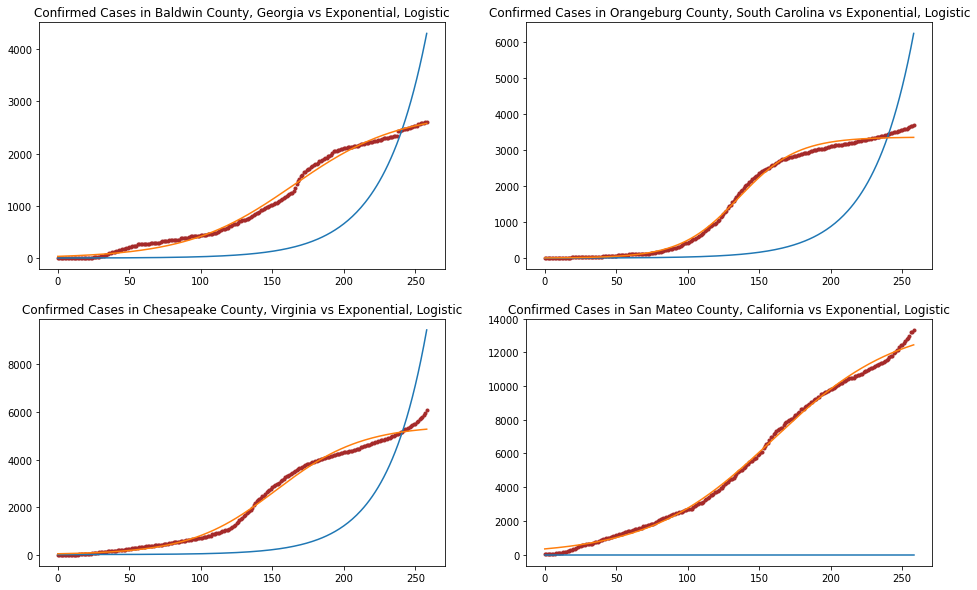

In [11]:
mask = (stats['Log_R^2'] >= r2_thresh) & (stats['Exp_R^2'] < 0.95)
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"]},
                    mask=mask)

## Time series that are better explained by dual logistic functions

Let's examine cases where a mixture of two logistic growth models explains
the data better than a single logistic growth model.

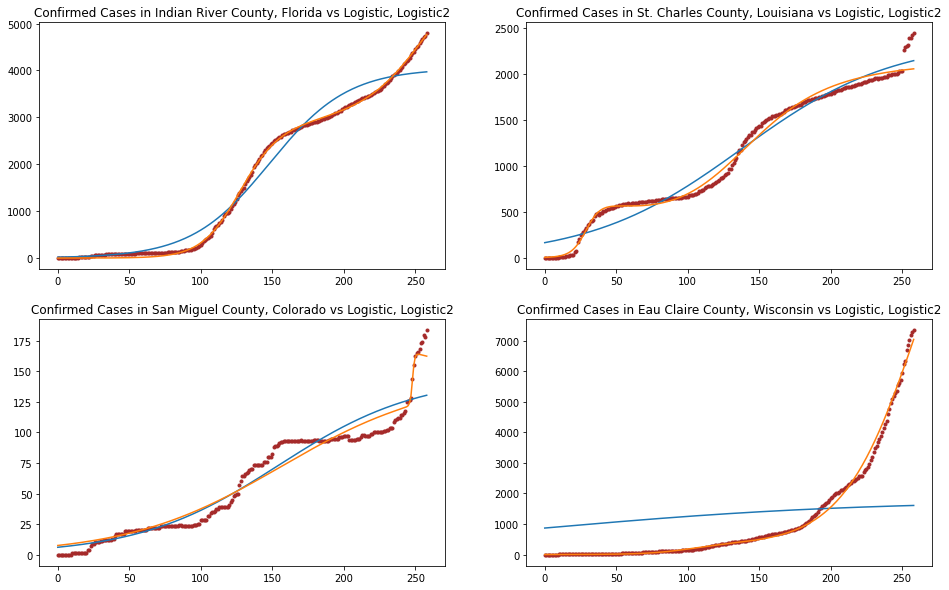

In [12]:
mask = stats['Log2_R^2'] - stats['Log_R^2'] >= 0.01
#graph_examples(mask, {"Logistic": logistic, "Logistic2": logistic2}, num_to_pick=10)
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=mask)

## Time series where recent data looks like a straight line

Many of the dual-logistic curves have low values for the rate of the
second logistic function, indicating a curve where the later parts of the
curve look more like a straight line. 
Across the entire data set, what models have logistic rate2 near zero?

In [13]:
small_rate2_mask = (stats['Log2_R^2'] >= r2_thresh) & (params["Log2_Rate2"] < 5e-2)
params[small_rate2_mask][metadata_cols + [c for c in params.columns if c.startswith("Log2")]]

,State,County,Population,Log2_Max1,Log2_Rate1,Log2_Offset1,Log2_Max2,Log2_Rate2,Log2_Offset2,Log2_Switch_Begin,Log2_Switch_End
FIPS,,,,,,,,,,,
1001,Alabama,Autauga,55869,712.386798,0.072317,117.666975,6595.429632,0.000972,258.999811,211.681399,258.999964
1007,Alabama,Bibb,22394,1037.938977,0.105521,236.273356,1083.114902,0.035398,138.899231,0.028724,259.000000
1011,Alabama,Bullock,10101,1015.289567,10.000000,259.000000,725.012710,0.019291,117.070681,67.996131,73.202984
1019,Alabama,Cherokee,26196,981.226719,0.101973,247.544802,1109.546003,0.034105,163.671699,0.000038,259.000000
1023,Alabama,Choctaw,12589,711.463304,10.000000,259.000000,805.142035,0.007075,237.890064,63.120883,81.835474
...,...,...,...,...,...,...,...,...,...,...,...
55125,Wisconsin,Vilas,22195,2088.232258,0.026181,258.999587,2366.973782,0.039260,259.000000,9.999986,19.999913
55135,Wisconsin,Waupaca,50990,844.398926,9.999925,51.699779,8345.273173,0.030314,259.000000,0.999523,0.000000
55137,Wisconsin,Waushara,24443,2740.423684,10.000000,259.000000,3103.206570,0.041342,248.150964,10.011718,20.052797


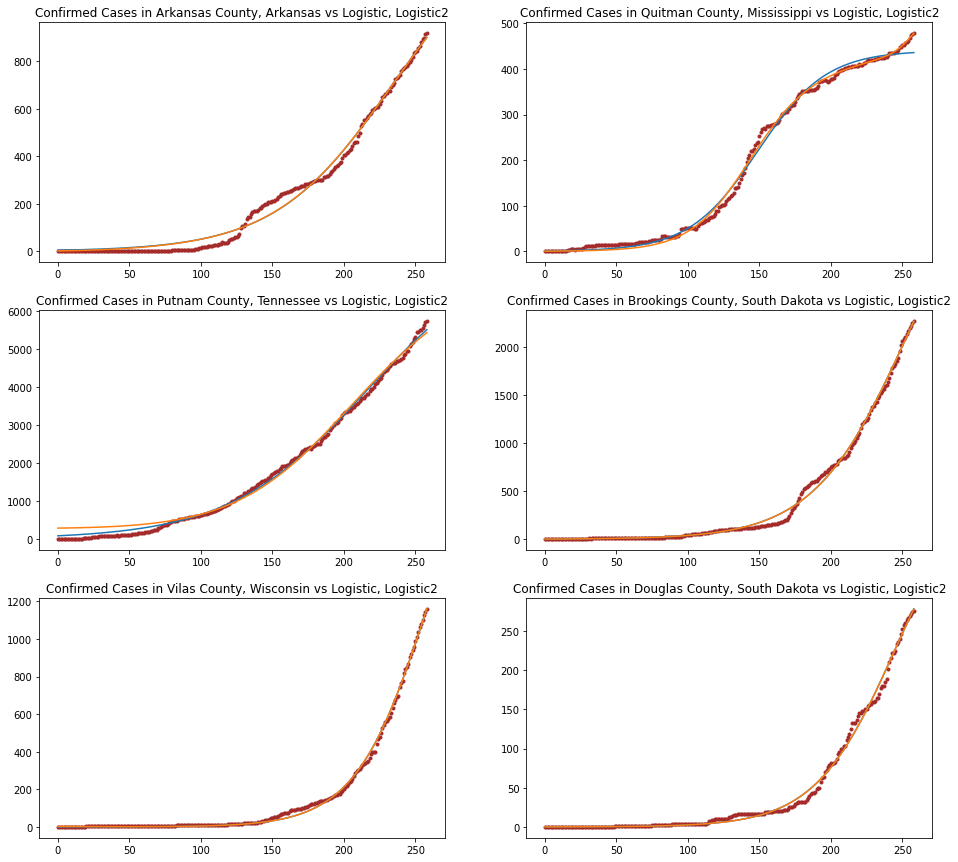

In [14]:
# Show some examples of these cases where Rate2 is small
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=small_rate2_mask,
                    num_to_pick=6)

## Time series that can explained by steep logistic growth

Look at counties for which the rate for the single-logistic-curve fit is large. 
A high rate corresponds to a "steep" instance of the logistic function that 
transisitions abruptly between different regimes.

In [15]:
large_rate_mask = (
    (stats['Log_R^2'] >= r2_thresh) 
    & (params["Log_Rate"] > 2e-1))
params[large_rate_mask][metadata_cols + [c for c in params.columns 
                                         if (c.startswith("Log")
                                             and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
2016,Alaska,Aleutians West,5634,95.284204,1.000000,131.072678
12067,Florida,Lafayette,8422,1245.677435,0.456370,156.751371
48283,Texas,La Salle,7520,365.725589,0.414735,128.709958


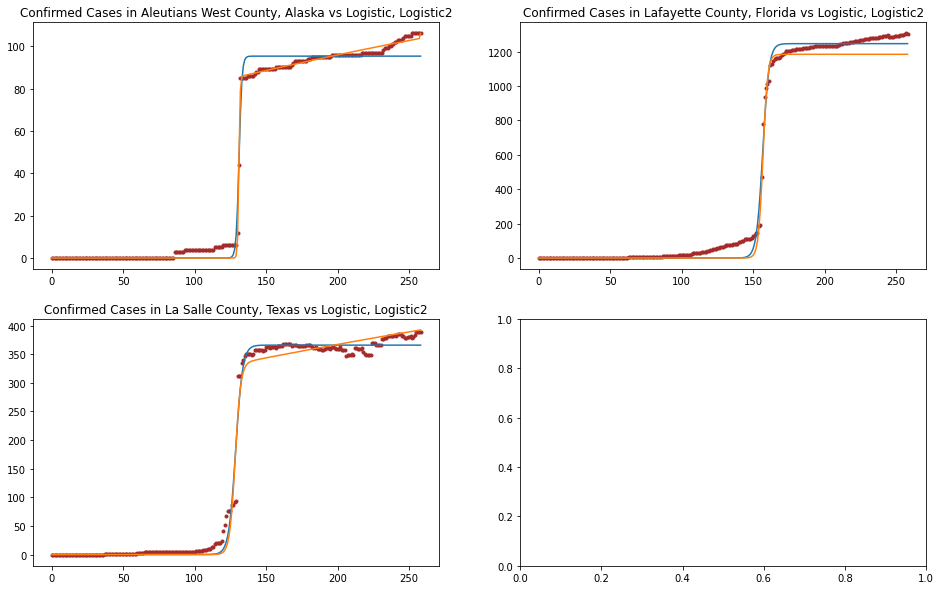

In [16]:
# Show some examples of these cases where Rate is large
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=large_rate_mask,
                    num_to_pick=10)

## Time series that appear to be in the early phases of logistic growth

In [17]:
early_mask = (
    (stats['Log_R^2'] >= r2_thresh) & (params["Log_Offset"] > 80))
params[early_mask][metadata_cols + [c for c in params.columns 
                                    if (c.startswith("Log") and not c.startswith("Log2"))]]

,State,County,Population,Log_Max,Log_Rate,Log_Offset
FIPS,,,,,,
1001,Alabama,Autauga,55869,2588.942416,0.025243,165.522271
1005,Alabama,Barbour,24686,1136.381406,0.027183,146.296390
1019,Alabama,Cherokee,26196,1069.794804,0.026894,192.522766
1021,Alabama,Chilton,44428,2186.006246,0.032752,170.004565
1027,Alabama,Clay,13235,939.380880,0.032960,186.451021
...,...,...,...,...,...,...
55125,Wisconsin,Vilas,22195,2366.950553,0.039259,259.000000
55135,Wisconsin,Waupaca,50990,8345.302421,0.030314,259.000000
55137,Wisconsin,Waushara,24443,3103.234852,0.041342,248.151392


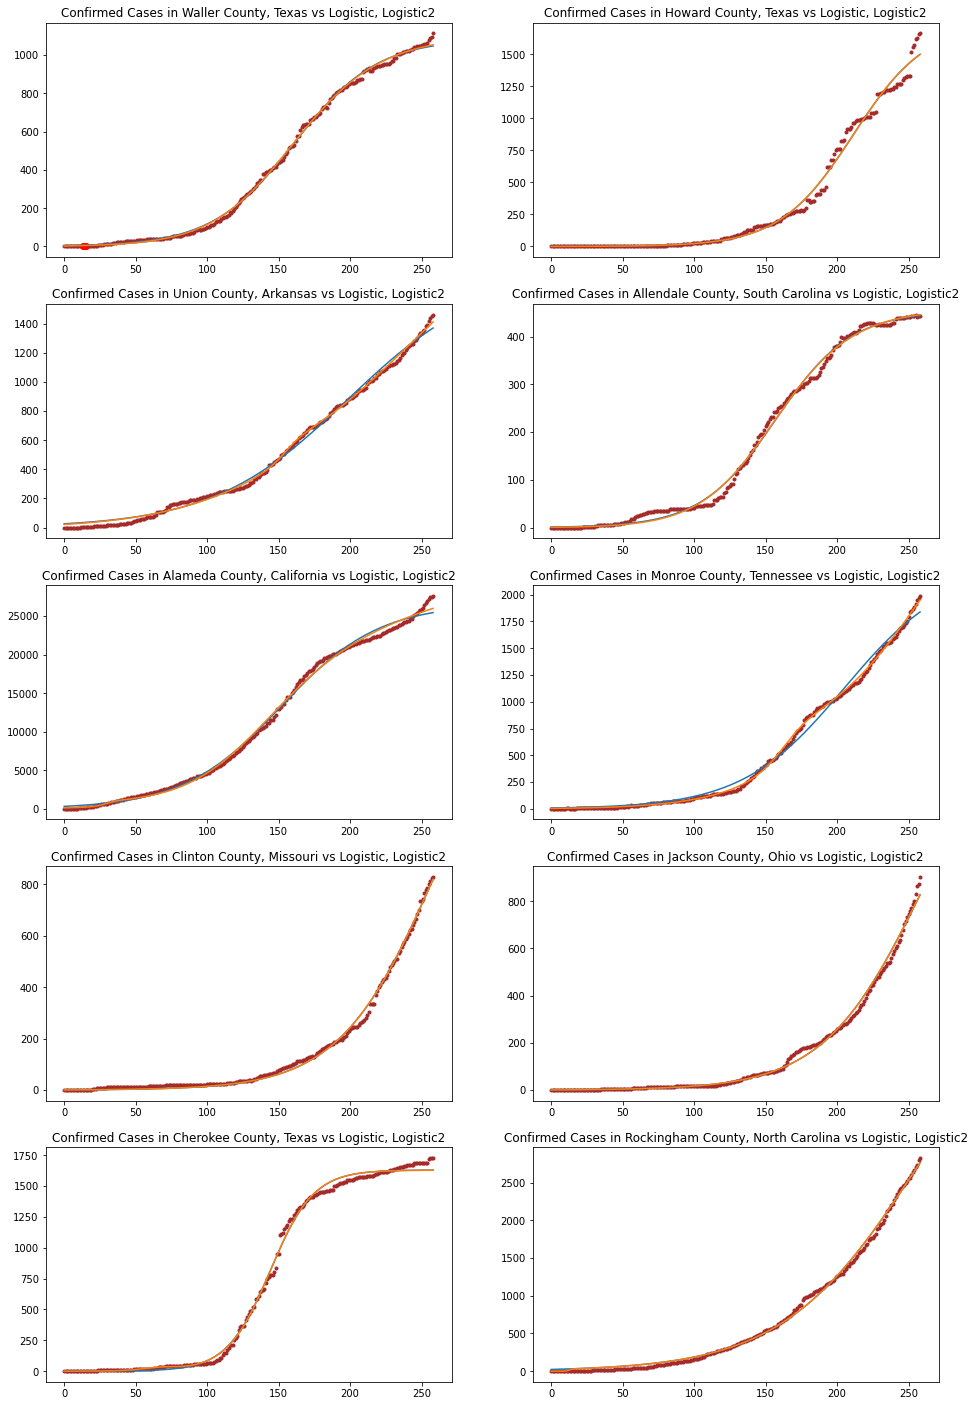

In [18]:
# Graphs of counties for which the logistic curve fit is currently
# in the early phases of logistic growth
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=early_mask,
                    num_to_pick=10)

## Time series for counties with high population

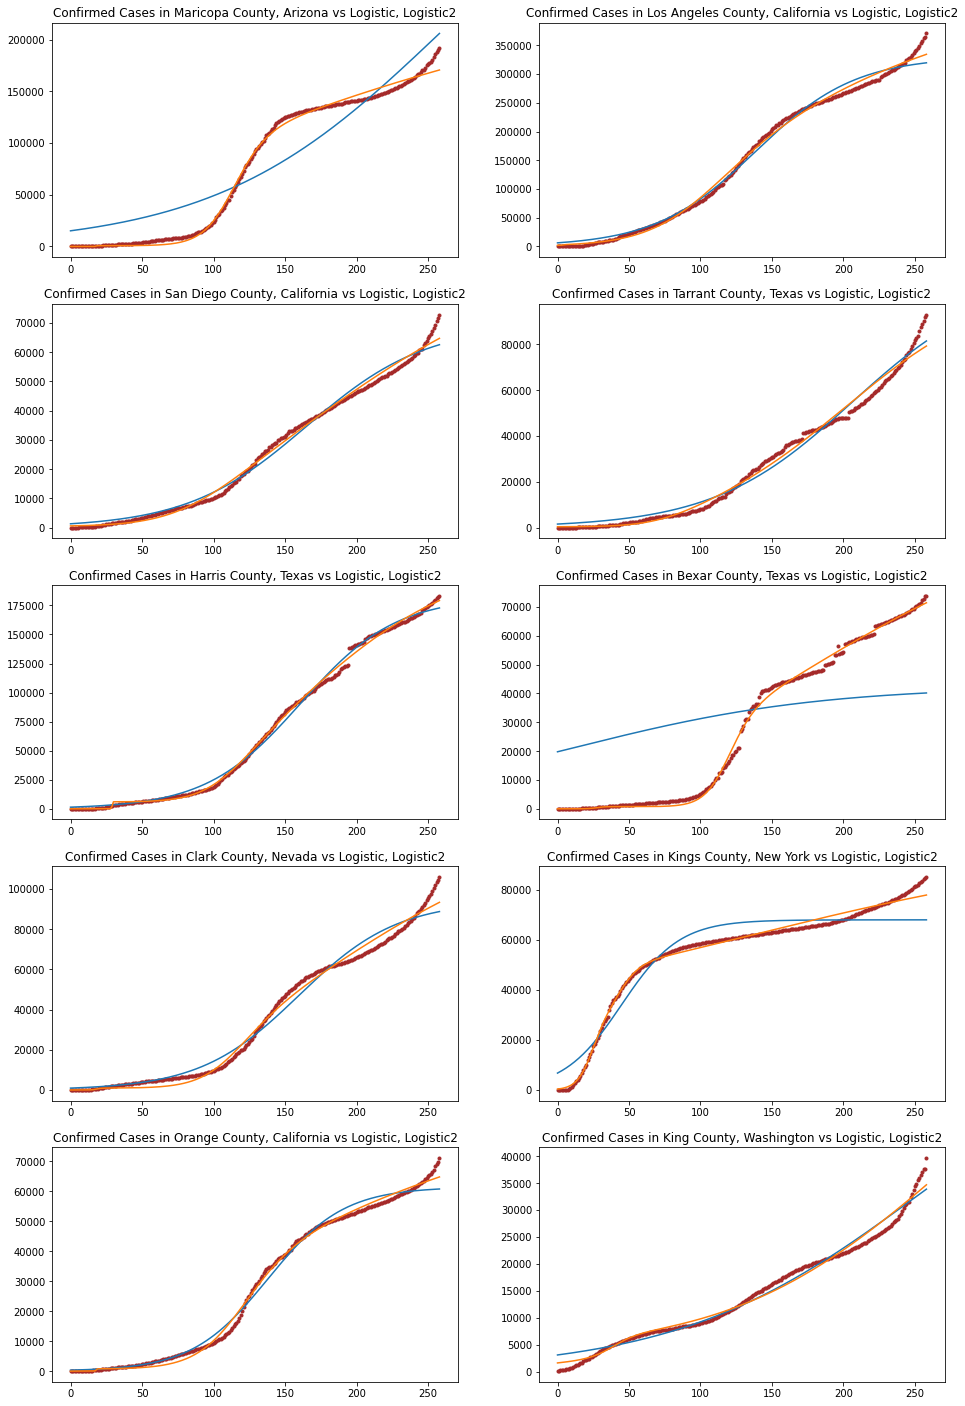

In [19]:
util.graph_examples(curves, ts_col_name, 
                    {"Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=curves["Population"] > 2e6,
                    num_to_pick=10)

## Time series that  *not* explained by any of our curves

In [20]:
non_fitting_mask = (stats["Exp_R^2"] < 0.99) & (stats["Log_R^2"] < 0.99) & (stats["Log2_R^2"] < 0.99)
stats[non_fitting_mask]

,State,County,Population,Exp_R^2,Log_R^2,Log2_R^2
FIPS,,,,,,
1003,Alabama,Baldwin,223234,0.282758,0.987364,0.986051
1009,Alabama,Blount,57826,0.537894,0.982982,0.453860
1013,Alabama,Butler,19448,-0.569495,0.973497,0.974930
1015,Alabama,Calhoun,113605,-0.855528,0.989886,0.989894
1017,Alabama,Chambers,33254,-0.318793,0.983633,0.826994
...,...,...,...,...,...,...
56037,Wyoming,Sweetwater,42343,0.873723,0.874225,0.874243
56039,Wyoming,Teton,23464,0.740683,0.967678,0.967809
56041,Wyoming,Uinta,20226,0.679381,0.911987,0.915456


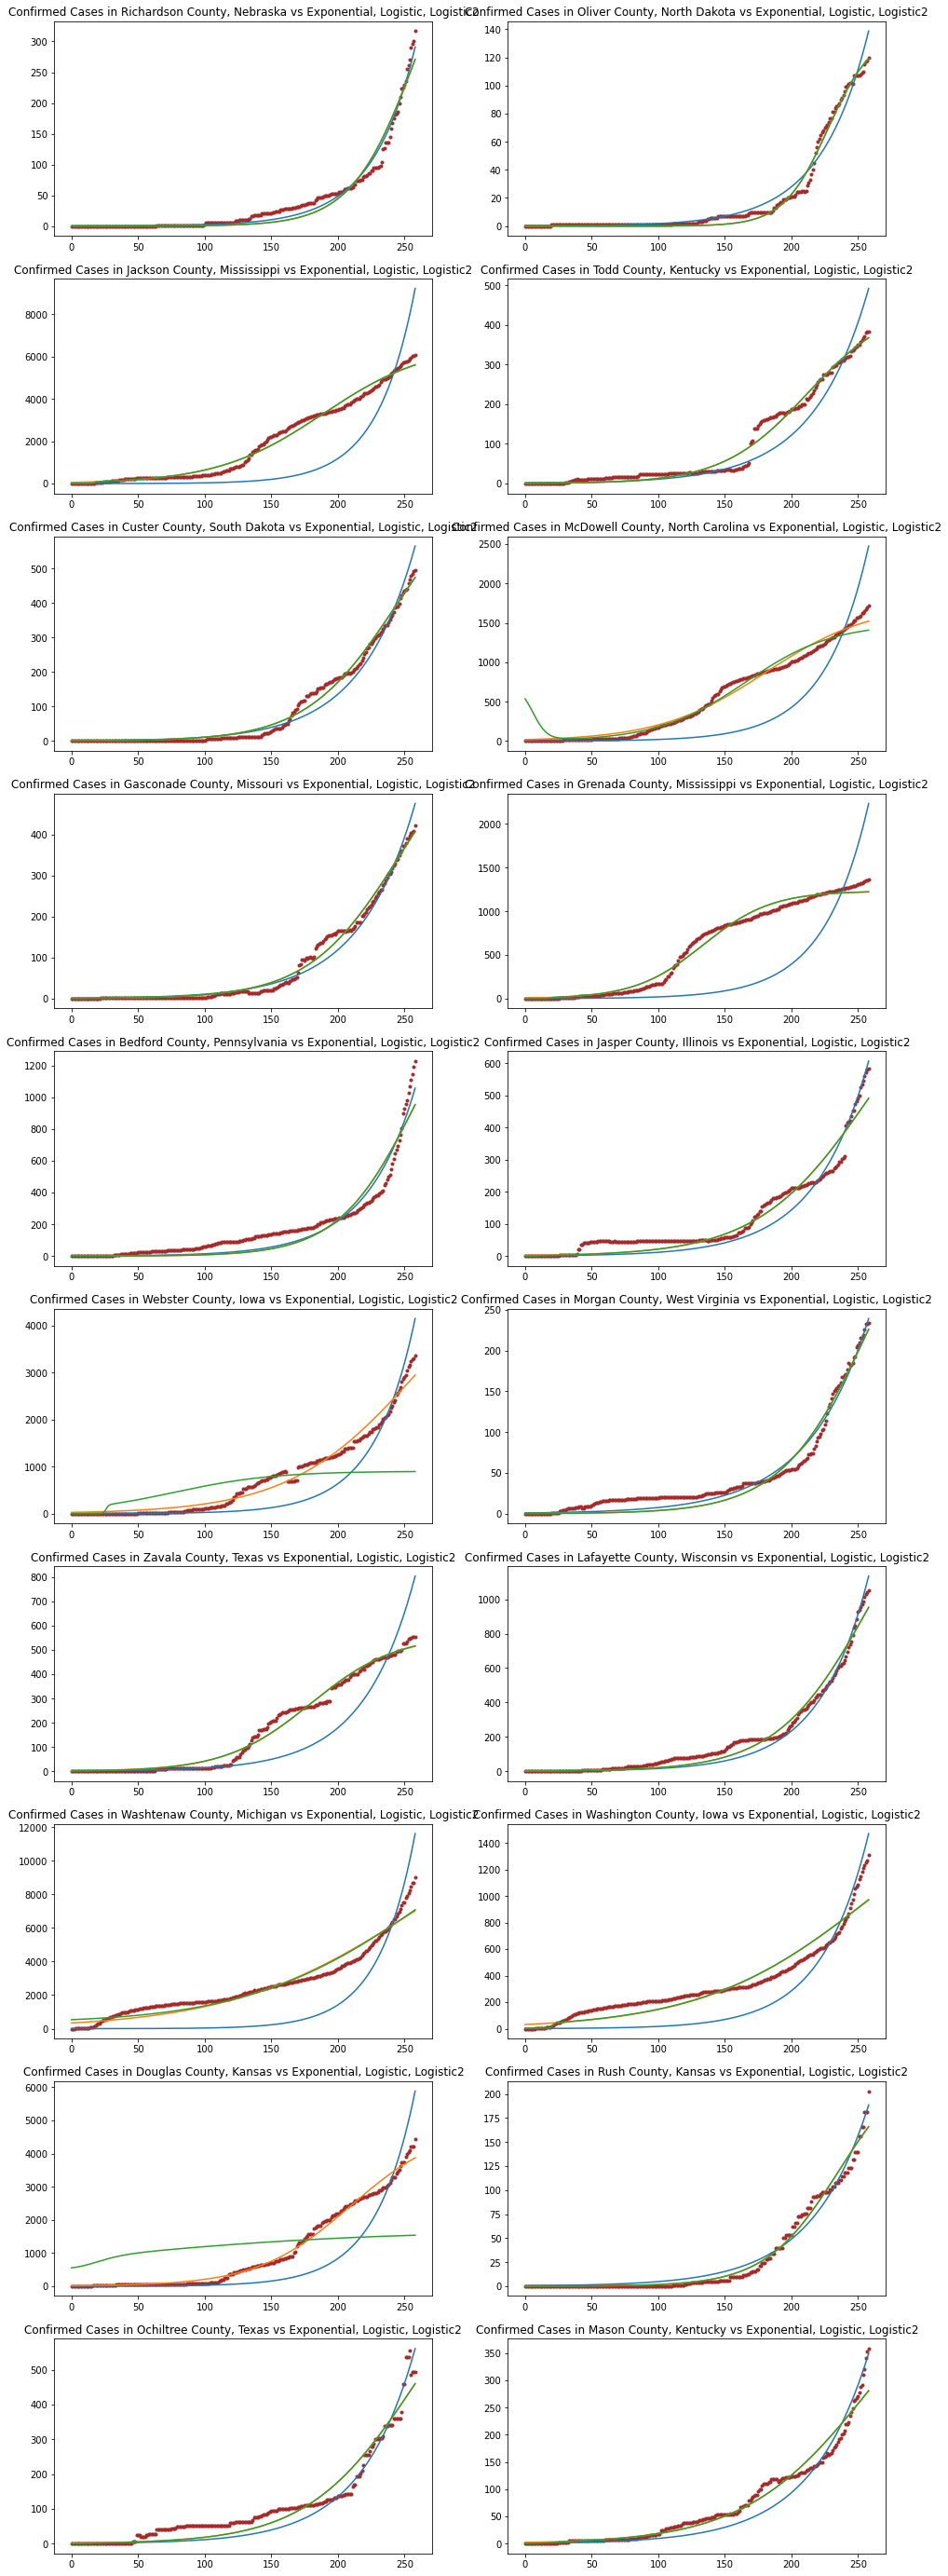

In [21]:
util.graph_examples(curves, ts_col_name, 
                    {"Exponential": curves["Exponential"],
                     "Logistic": curves["Logistic"],
                     "Logistic2": curves["Logistic2"]},
                    mask=non_fitting_mask,
                    num_to_pick=20)